In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model

import model2 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss
from lovasz_loss import lovasz_hinge_flat

In [10]:
torch.cuda.is_available()
device = torch.device('cuda')

# Setup Dataset

In [11]:
train_df, val_df, _ = get_dfs()

In [12]:
train_dataset = SegmentationDataset(train_df, size=(128, 128), use_depth_channels=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), use_depth_channels=True, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training

In [15]:
gc.collect()
torch.cuda.empty_cache()

model = M.UNetRes34(n_classes=1, pretrained_resnet=True)
model = model.to(device)

#criterion = FocalLoss(gamma=2.0, alpha=0.25)
criterion = nn.BCEWithLogitsLoss()
#criterion = FocalLoss(gamma=2.0, alpha=0.25)
#criterion = lovasz_hinge_flat
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Loaded pretrained resnet weights


In [16]:
def train(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target) in enumerate(train_iter):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            
            # Forward
            output = model(data)
            loss = criterion(output.view(-1), target.view(-1))
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            #iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
            iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [17]:
model = train(model, 20, train_loader, val_loader)

[2018-10-07 16:30:33.559280] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.043920
[2018-10-07 16:30:44.949488] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.039822
[2018-10-07 16:30:56.361898] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.037940
[2018-10-07 16:31:07.717601] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.036906
[2018-10-07 16:31:07.717601] Train Epoch: 0	IoU: 0.390000
[2018-10-07 16:31:25.845447] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.030745
[2018-10-07 16:31:37.243809] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.032733
[2018-10-07 16:31:48.601592] Train Epoch: 1 [1600/3200 (50%)]	Average loss: 0.032313
[2018-10-07 16:31:59.978915] Train Epoch: 1 [2400/3200 (75%)]	Average loss: 0.032227
[2018-10-07 16:31:59.978915] Train Epoch: 1	IoU: 0.390000
[2018-10-07 16:32:18.049267] Train Epoch: 2 [0/3200 (0%)]	Average loss: 0.026739
[2018-10-07 16:32:29.479679] Train Epoch: 2 [800/3200 (25%)]	Average loss: 0.031453
[2018-10-07 16:32:40.906241] Train Epoch: 2 [1600

In [18]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

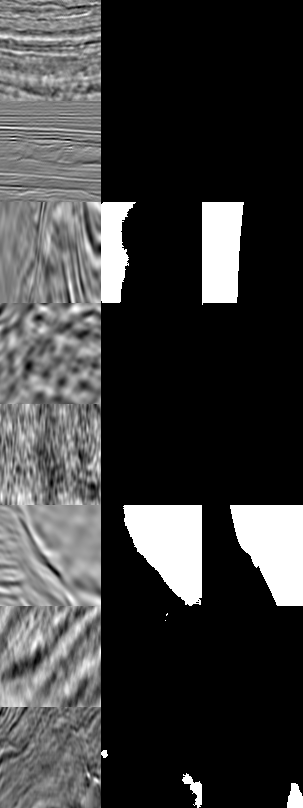

In [19]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

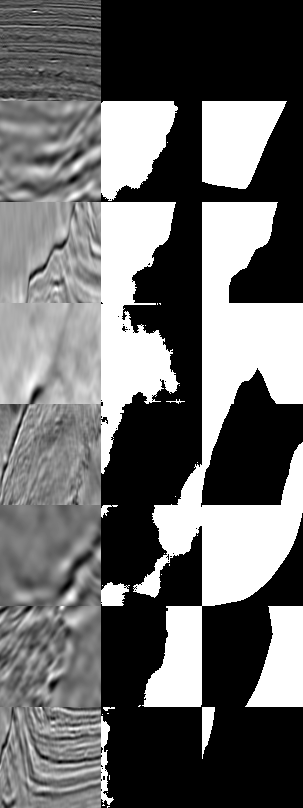

In [20]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

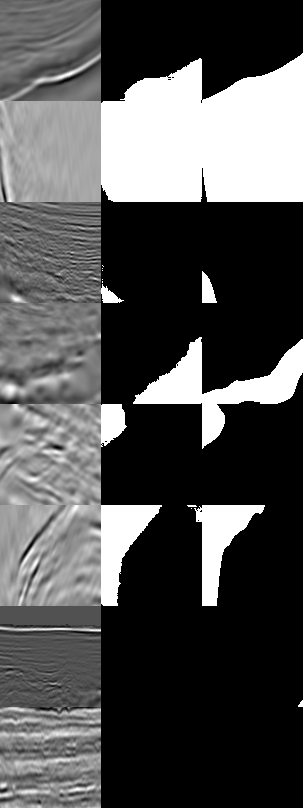

In [21]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)

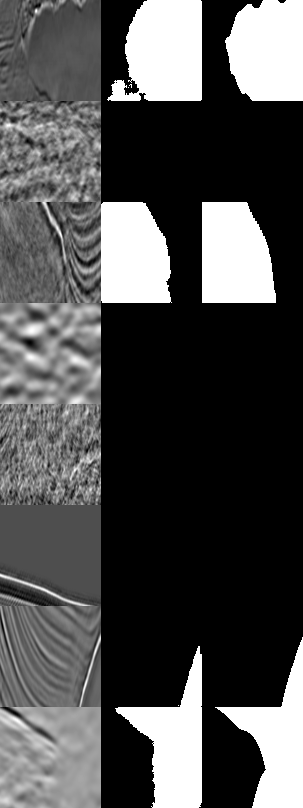

In [22]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=False)
show_prediction(im, pred, t)